#### <b>Prepare Source Codes</b>

* Reference: https://github.com/genforce/interfacegan

In [2]:
!git clone https://github.com/ndb796/interfacegan
%cd interfacegan

Cloning into 'interfacegan'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 11.39 MiB | 26.69 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/interfacegan


#### <b>Prepare the Pre-trained StyleGAN Model</b>

* Reference: https://github.com/NVlabs/stylegan
* Load PyTorch model weights.

In [3]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcS2SF2JUNxLqI2KVi_GPUcB2IuYfsTqCPZ6UkiFr-dl3Q?download=1 -O ./models/pretrain/stylegan_ffhq.pth

--2021-03-13 19:16:26--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcS2SF2JUNxLqI2KVi_GPUcB2IuYfsTqCPZ6UkiFr-dl3Q?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_ffhq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FY1MyU0YySlVOeExxSTJLVmlfR1BVY0IySXVZZnNUcUNQWjZVa2lGci1kbDNRP3J0aW1lPWN5UHVmMVRtMkVn [following]
--2021-03-13 19:16:27--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_ffhq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FY1MyU0YySlVOeExxS

In [2]:
from models.model_settings import MODEL_POOL

print(list(MODEL_POOL))

['pggan_celebahq', 'stylegan_celebahq', 'stylegan_ffhq']


#### <b>Prepare Dataset</b>

* Reference: https://github.com/jacobhallberg/pytorch_stylegan_encoder

In [5]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdtYI8n9u3tAg81HgfvmV7oBQP59rE984-y33HFXeYxbMg?download=1 -O StyleGANLatentVectorDatasetTruncation80.zip
!unzip StyleGANLatentVectorDatasetTruncation80.zip -d ./
!mv ./output ./StyleGANLatentVectorDatasetTruncation80

In [3]:
import torch
from torchvision import transforms
from torchvision.models import resnet18

from PIL import Image
from glob import glob
import numpy as np


class ImageLatentDataset(torch.utils.data.Dataset):
    def __init__(self, file_names, dlatents, transforms=None):
        self.file_names = file_names
        self.dlatents = dlatents
        self.transforms = transforms

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        filename = self.file_names[index]
        dlatent = self.dlatents[index]

        image = np.asarray(Image.open(filename))
        image = Image.fromarray(np.uint8(image))

        if self.transforms:
            image = self.transforms(image)
        return image, dlatent

In [4]:
transforms_custom = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

directory = "./StyleGANLatentVectorDatasetTruncation80/"
file_names = sorted(glob(directory + "*.jpg"))
print(f'There are {len(file_names)} images.')

num_of_trains = 72000
train_file_names = file_names[:num_of_trains]
val_file_names = file_names[num_of_trains:]

dlatents = np.load(directory + "w_truncated.npy")

train_dlatents = dlatents[:num_of_trains]
val_dlatents = dlatents[num_of_trains:]
print(f'There are {len(dlatents)} latents.')

train_dataset = ImageLatentDataset(train_file_names, train_dlatents, transforms=transforms_custom)
val_dataset = ImageLatentDataset(val_file_names, val_dlatents, transforms=transforms_custom)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

There are 80000 images.
There are 80000 latents.


#### <b>Define Model Architecture</b>

In [5]:
class ImageToLatent(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = list(resnet18(pretrained=True).children())[:-2]
        self.resnet = torch.nn.Sequential(*self.resnet)
        self.conv2d = torch.nn.Conv2d(512, 128, kernel_size=1)
        self.flatten = torch.nn.Flatten()
        self.dense = torch.nn.Linear(8192, 512)

    def forward(self, image):
        x = self.resnet(image)
        x = self.conv2d(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = x.view((-1, 512))

        return x


class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l2_loss = torch.nn.MSELoss()
    
    def forward(self, true, pred):
        result = torch.mean(torch.abs(true - pred))
        result += self.l2_loss(true, pred) 
        return result


class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, true, pred):
        loss = true - pred
        return torch.mean(torch.log(torch.cosh(loss + 1e-12)))

In [15]:
regressor = ImageToLatent().cuda()
optimizer = torch.optim.Adam(regressor.parameters())
criterion = LogCoshLoss()

#### <b>Train the Model</b>

In [16]:
import time

epochs = 1
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    running_cnt = 0
    
    regressor.train()
    for i, (images, latents) in enumerate(train_dataloader):
        optimizer.zero_grad()

        images, latents = images.cuda(), latents.cuda()
        pred_latents = regressor(images)
        loss = criterion(pred_latents, latents)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        running_cnt += latents.shape[0]
        
        if i == 0 or (i + 1) % 50 == 0:
            print("Epoch: {}, Step: {}, Loss: {:4f}, Time Elapsed: {:4f}".format((epoch + 1), (i + 1), running_loss / running_cnt, time.time() - start_time))
    
    val_loss = 0.0
    val_cnt = 0.0
    
    regressor.eval()
    for i, (images, latents) in enumerate(val_dataloader):
        with torch.no_grad():
            images, latents = images.cuda(), latents.cuda()
            pred_latents = regressor(images)
            loss =  criterion(pred_latents, latents)
            
            val_loss += loss.item()
            val_cnt += latents.shape[0]

    print("Epoch: {}, Validation Loss: {:4f}, Time Elapsed: {:4f}".format((epoch + 1), val_loss / val_cnt, time.time() - start_time))

Epoch: 1, Step: 1, Loss: 0.004660, Time Elapsed: 0.254324
Epoch: 1, Step: 50, Loss: 0.003734, Time Elapsed: 12.190744
Epoch: 1, Step: 100, Loss: 0.002132, Time Elapsed: 24.313229
Epoch: 1, Step: 150, Loss: 0.001581, Time Elapsed: 36.425671
Epoch: 1, Step: 200, Loss: 0.001291, Time Elapsed: 48.550031
Epoch: 1, Step: 250, Loss: 0.001113, Time Elapsed: 60.644001
Epoch: 1, Step: 300, Loss: 0.000992, Time Elapsed: 72.739664
Epoch: 1, Step: 350, Loss: 0.000903, Time Elapsed: 84.876347
Epoch: 1, Step: 400, Loss: 0.000834, Time Elapsed: 97.005953
Epoch: 1, Step: 450, Loss: 0.000781, Time Elapsed: 109.099362
Epoch: 1, Step: 500, Loss: 0.000736, Time Elapsed: 121.219560
Epoch: 1, Step: 550, Loss: 0.000699, Time Elapsed: 133.401123
Epoch: 1, Step: 600, Loss: 0.000667, Time Elapsed: 145.566555
Epoch: 1, Step: 650, Loss: 0.000640, Time Elapsed: 157.705701
Epoch: 1, Step: 700, Loss: 0.000616, Time Elapsed: 169.820713
Epoch: 1, Step: 750, Loss: 0.000595, Time Elapsed: 181.911376
Epoch: 1, Step: 800, 

#### <b>Save and Load the Model</b>

In [ ]:
torch.save(regressor.state_dict(), "./regressor.pth")

regressor = ImageToLatent().cuda()
regressor.load_state_dict(torch.load("regressor.pth"))
regressor.eval()

#### <b>Test the Model</b>

In [7]:
from models.stylegan_generator import StyleGANGenerator


def normalized_to_normal_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 3, 1, 1).float()
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 3, 1, 1).float()
    
    image = image.detach().cpu()
    image *= std
    image += mean
    image *= 255
    
    image = image.numpy()
    image = np.transpose(image, (0, 2, 3, 1))

    return image.astype(np.uint8)


class PostSynthesisProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.min_value = -1
        self.max_value = 1

    def forward(self, synthesized_image):
        synthesized_image = (synthesized_image - self.min_value) * torch.tensor(255).float() / (self.max_value - self.min_value)
        synthesized_image = torch.clamp(synthesized_image + 0.5, min=0, max=255)

        return synthesized_image


synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)

[2021-03-13 19:48:27,781][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2021-03-13 19:48:28,073][INFO] Successfully loaded!
[2021-03-13 19:48:28,074][INFO]   `lod` of the loaded model is 0.0.


* <b>Visualization 1</b>

In [10]:
# Get normal images
num_test_images = 5
images = [val_dataset[i][0].unsqueeze(0).cuda() for i in range(num_test_images)]
normal_images = torch.cat(images, dim=0)
normal_images = normalized_to_normal_image(normal_images)
print(normal_images.shape)

# Get predicted latents
images = torch.cat(images, dim=0)
pred_dlatents = regressor(images).view(num_test_images, 1, 512)
pred_dlatents = pred_dlatents.expand(num_test_images, 18, 512)
print(pred_dlatents.shape)

# Get predicted images
pred_images = synthesizer(pred_dlatents)
pred_images = post_process(pred_images)
pred_images = np.transpose(pred_images, (0, 2, 3, 1))
print(pred_images.shape)

(5, 256, 256, 3)
torch.Size([5, 18, 512])
(5, 1024, 1024, 3)


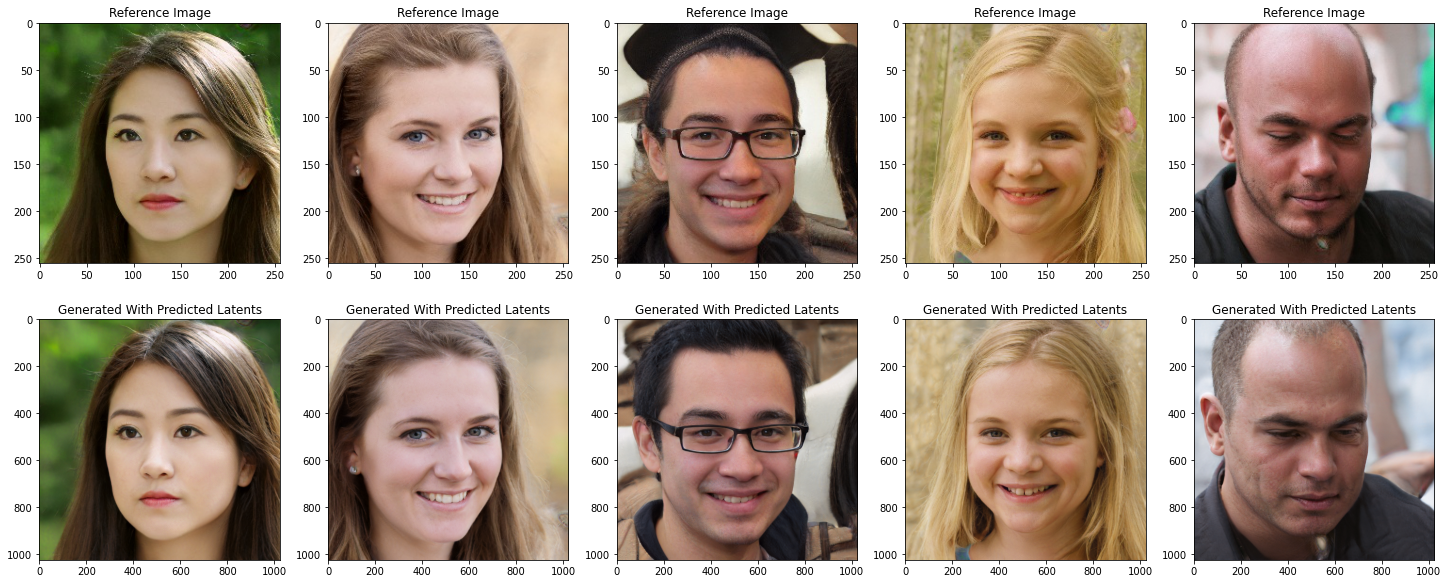

In [11]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(25, 10))
columns = len(normal_images)
rows = 2

axis = []

for i in range(columns):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Reference Image")
    plt.imshow(normal_images[i])

for i in range(columns, columns * rows):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Generated With Predicted Latents")
    plt.imshow(pred_images[i - columns])

plt.show()

* <b>Visualization 2</b>

In [9]:
# Get normal images
num_test_images = 5
images = [val_dataset[i][0].unsqueeze(0).cuda() for i in range(5, 5 + num_test_images)]
normal_images = torch.cat(images, dim=0)
normal_images = normalized_to_normal_image(normal_images)
print(normal_images.shape)

# Get predicted latents
images = torch.cat(images, dim=0)
pred_dlatents = regressor(images).view(num_test_images, 1, 512)
pred_dlatents = pred_dlatents.expand(num_test_images, 18, 512)
print(pred_dlatents.shape)

# Get predicted images
pred_images = synthesizer(pred_dlatents)
pred_images = post_process(pred_images)
pred_images = np.transpose(pred_images, (0, 2, 3, 1))
print(pred_images.shape)

(5, 256, 256, 3)
torch.Size([5, 18, 512])
(5, 1024, 1024, 3)


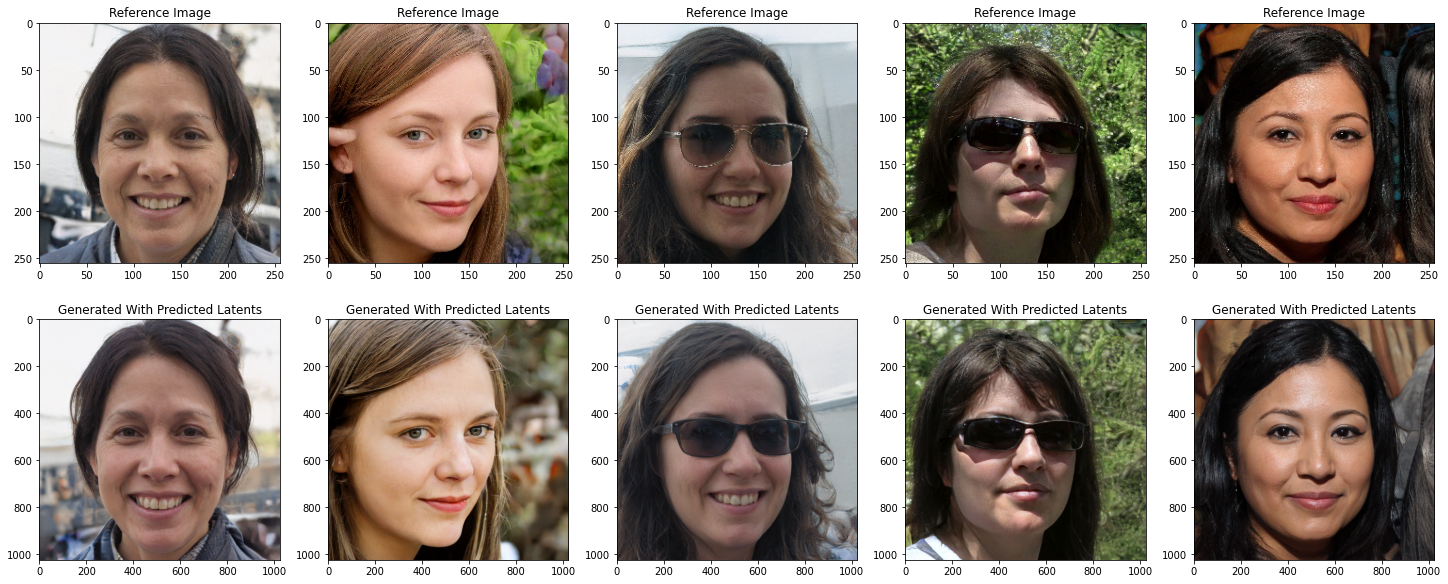

In [10]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(25, 10))
columns = len(normal_images)
rows = 2

axis = []

for i in range(columns):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Reference Image")
    plt.imshow(normal_images[i])

for i in range(columns, columns * rows):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Generated With Predicted Latents")
    plt.imshow(pred_images[i - columns])

plt.show()

### <b>CelebA Dataset Download</b>

<pre>
<b>Dataset/</b>
    <b>test/</b>
        male/
        female/
</pre>

In [19]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ET8NMz2sl2ZEtlUVi5Hs-cIBS9VJhWixX8BM9uC1H1PnPg?download=1 -O CelebA_HQ_face_gender_dataset_test_1000.zip
!unzip CelebA_HQ_face_gender_dataset_test_1000.zip -d ./CelebA_HQ_face_gender_dataset_test_1000

In [8]:
from torchvision import datasets, models, transforms
import os

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = './CelebA_HQ_face_gender_dataset_test_1000/CelebA_HQ_face_gender_dataset_test_1000/'

test_dataset = datasets.ImageFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 1000
Class names: ['female', 'male']


In [9]:
# Get normal images
num_test_images = 5
images = [test_dataset[i][0].unsqueeze(0).cuda() for i in range(num_test_images)]
normal_images = torch.cat(images, dim=0)
normal_images = normalized_to_normal_image(normal_images)
print(normal_images.shape)

# Get predicted latents
images = torch.cat(images, dim=0)
pred_dlatents = regressor(images).view(num_test_images, 1, 512)
pred_dlatents = pred_dlatents.expand(num_test_images, 18, 512)
print(pred_dlatents.shape)

# Get predicted images
pred_images = synthesizer(pred_dlatents)
pred_images = post_process(pred_images)
pred_images = np.transpose(pred_images, (0, 2, 3, 1))
print(pred_images.shape)

(5, 256, 256, 3)
torch.Size([5, 18, 512])
(5, 1024, 1024, 3)


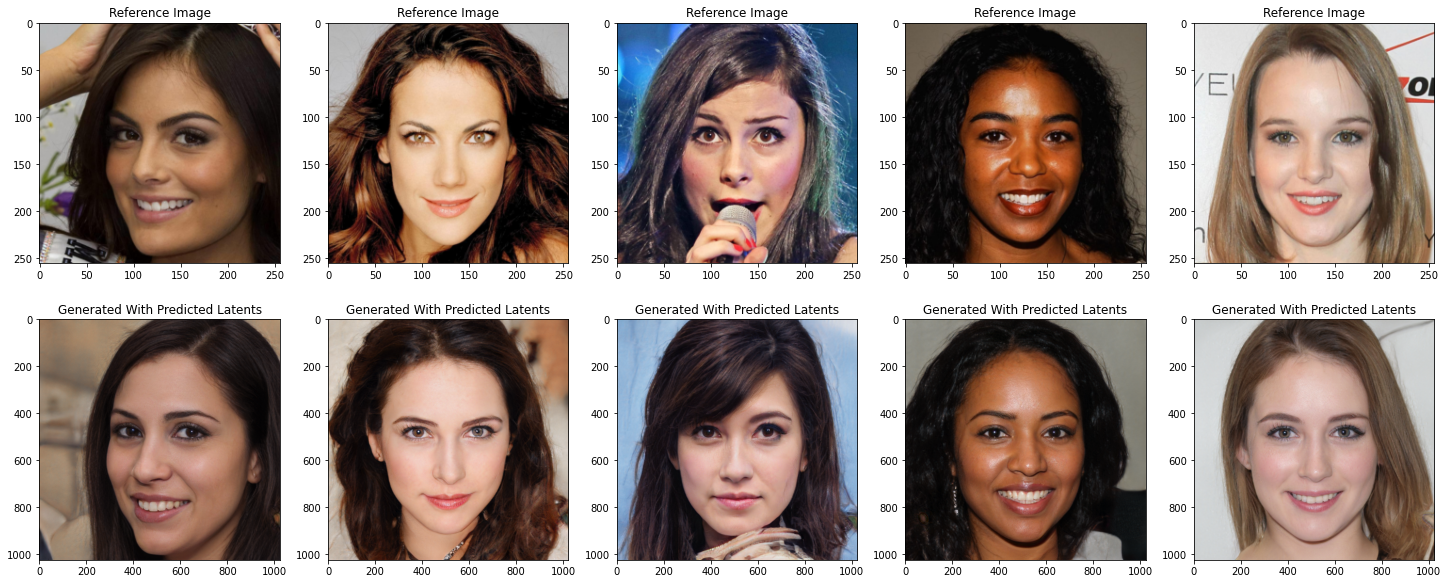

In [10]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(25, 10))
columns = len(normal_images)
rows = 2

axis = []

for i in range(columns):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Reference Image")
    plt.imshow(normal_images[i])

for i in range(columns, columns * rows):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Generated With Predicted Latents")
    plt.imshow(pred_images[i - columns])

plt.show()